# Prediction of Chl-a from TN and TP using Neural Networks

Reference: Escober, E. and Espino, M.P. (2023). A new trophic state index for assessing eutrophication of Laguna de Bay, Philippines. Environmental Advances, Vol. 13, 100410. doi: 10.1016/j.envadv.2023.100410

In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("chlor.csv")
df.head()

,Chl_a,Phy,NO2,NO3,NH4,PO4,Site,Bay,Depth
0,6.66,0.74,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.097
1,6.45,0.78,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
2,6.27,0.77,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
3,6.13,0.58,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004
4,6.10,0.57,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004


In [2]:
print(f'No. of rows: {len(df)}')

df.dropna(inplace=True)
df.drop(['Phy'], axis=1, inplace=True)

print(f'After removing missing values: {len(df)}')

No. of rows: 255
After removing missing values: 109


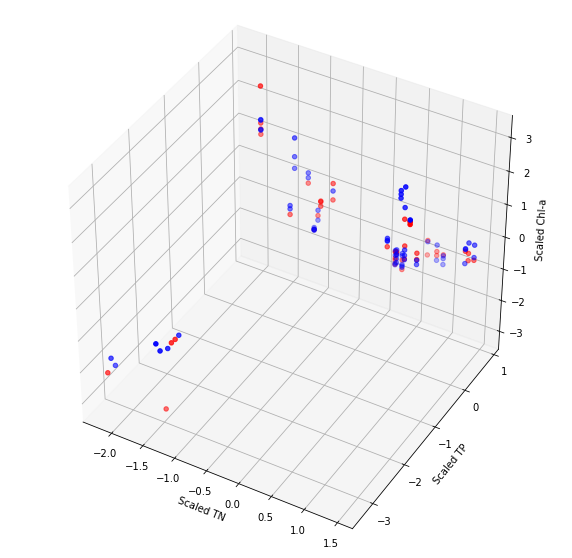

In [3]:
# Get the [NO2-], [NO3-], [NH4+], and [PO43-] as "X", then Chl-a as "y"
X, y = df.iloc[:,1:5].to_numpy(), df['Chl_a'].to_numpy()

# Create a new X with TN and TP as the columns
X = np.hstack((X[:,:2].sum(axis=1, keepdims=True), X[:,-1].reshape(-1,1)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=df['Site'])
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Visualize the data as a 3d scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train_scaled[:,0], X_train_scaled[:,1], y_train_scaled, c='b')
ax.scatter(X_test_scaled[:,0], X_test_scaled[:,1], y_test_scaled, c='r')
ax.set_xlabel('Scaled TN')
ax.set_ylabel('Scaled TP')
ax.set_zlabel('Scaled Chl-a')
ax.view_init(elev=40)

Training R2: 0.7204507500161551
Testing R2:  0.8189604032745008


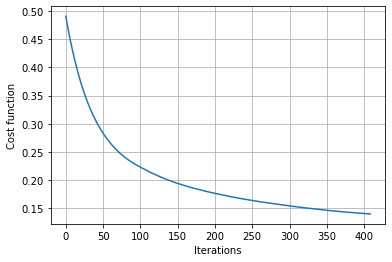

In [4]:
ANN = MLPRegressor(hidden_layer_sizes=50, max_iter=1000, activation='relu', random_state=0)
ANN.fit(X_train_scaled, y_train_scaled.ravel())

plt.plot(ANN.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.grid()

print(f"Training R2: {ANN.score(X_train_scaled, y_train_scaled)}")
print(f"Testing R2:  {ANN.score(X_test_scaled, y_test_scaled)}")

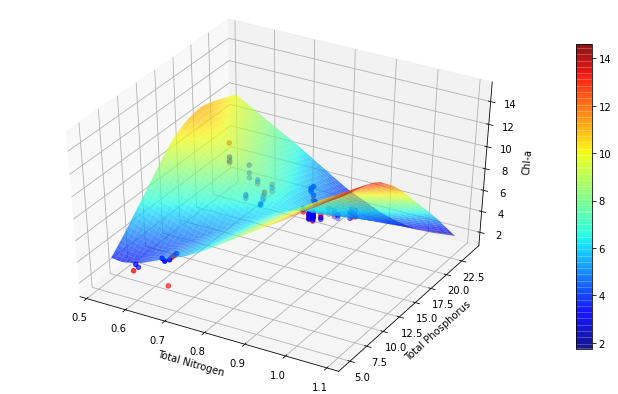

In [5]:
# Visualize the surface of predicted Chl-a for any TN, TP combination
vx, vy = np.meshgrid(np.linspace(-3,3,200),np.linspace(-3,3,200))

X_grid = np.hstack((vx.reshape(-1,1), vy.reshape(-1,1)))
vz = ANN.predict(X_grid)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, c='b')
ax.scatter(X_test[:,0], X_test[:,1], y_test, c='r')
ax.set_xlabel('Total Nitrogen')
ax.set_ylabel('Total Phosphorus')
ax.set_zlabel('Chl-a')
ax.view_init(elev=40)

X_grid = scaler_X.inverse_transform(X_grid)
Z = scaler_y.inverse_transform(vz.reshape(-1,1))
surf = ax.plot_surface(X_grid[:,0].reshape(vx.shape),
                       X_grid[:,1].reshape(vx.shape), 
                       Z.reshape(vx.shape),
                       linewidth=0,
                       cmap=cm.jet,
                       alpha = 0.7)
fig.colorbar(surf, shrink=0.8)
plt.show()